In [9]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
from scipy.misc import imresize

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
genotypes_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/GenotypeFiles/phg000520.v2.GTEx_MidPoint_Imputation.genotype-calls-vcf.c1/parse_data/GTEx_Analysis_20150112_OMNI_2.5M_5M_450Indiv_chr1to22_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs_all_chrom_filered_maf_subset_individuals_44_tissues.hdf5'
expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_*_normalised_without_inverse_gene_expression.txt'
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

def sigmoid(x):
    return 1 / (1 + np.exp(-np.array(x)))

model = build_empty_model()
model.load_weights('../models/inception_50_-1_gs1.h5')
final_layer_model = Model(model.input, model.layers[-2].output)

ID = 'GTEX-133LE-0526'
patches = pickle.load(open('../data/processed/covering_patches/{}/{}/{}'.format('Lung',ID,'GTEX-133LE-0526_16000'), 'rb'))

In [2]:
def maximise_ith_component(image, component, steps):
    print ('generating iteration function')
    # build a loss function that maximizes the activation of the ith filter 
    input_img = final_layer_model.layers[0].input
    layer_output = final_layer_model.layers[-1].output
    loss = K.mean(layer_output[:,component])
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])
    
    print ('performing gradient ascent')
    example_image = process_image(image)
    input_img_data = example_image.copy()
    original_img_data = example_image.copy()
    step = 1.
    for i in range(steps):
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step
        if i % 20 == 0:
            print (i, loss_value)
    
    
    
    f,a = plt.subplots(1,2, figsize=(15,5))
    f.suptitle("Component {}".format(component))
    a[0].imshow(np.squeeze(input_img_data))
    a[0].set_title("Modified")
    a[1].imshow(np.squeeze(original_img_data))
    a[1].set_title("Original")

In [24]:
def process_image(image):
    image = image.astype(np.float32)
    image = imresize(image, (299,299,3))
    image = np.expand_dims(image,0) / 255
    return image
    

In [23]:
noise_image = np.random.randint(0,255,size=[128,128,3])
noi.astype(np.float32)

In [26]:
final_layer_model.predict(process_image(noise_image))

array([[   0.        ,   75.12518311,   49.40391922, ...,  301.66113281,
         755.86730957,   69.29356384]], dtype=float32)

In [3]:
maximise_ith_component(noise_image, 1, 200)

NameError: name 'noise_image' is not defined

generating iteration function
performing gradient ascent
0 9633.69
20 10482.4
40 11317.2
60 12128.1
80 12910.0
100 13699.6
120 14472.0
140 15192.5
160 15875.2
180 16531.5


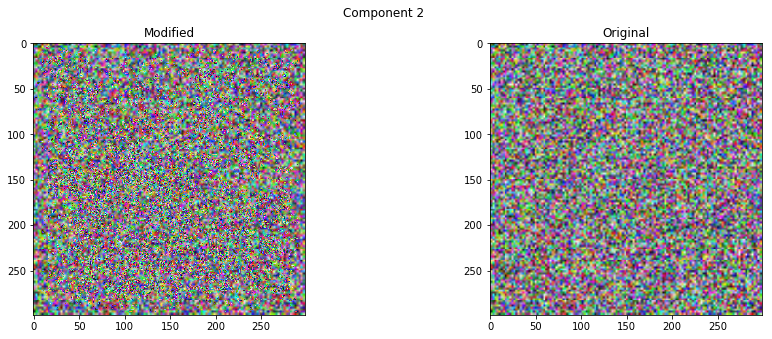

In [32]:
maximise_ith_component(noise_image, 2, 200)

generating iteration function
performing gradient ascent
0 45339.9
20 46539.8
40 47727.3
60 48911.7
80 50118.8
100 51335.2
120 52586.0
140 53880.0
160 55214.0
180 56535.2


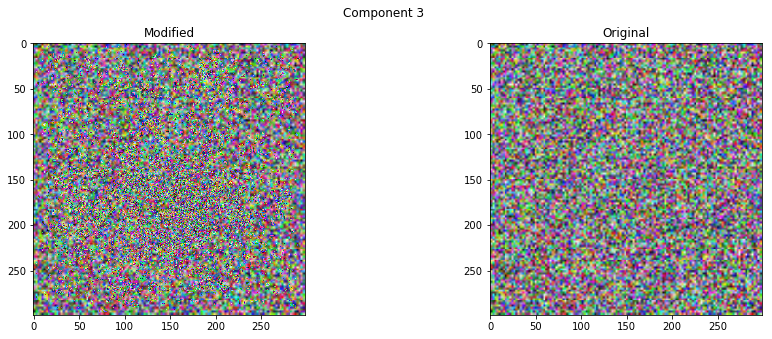

In [33]:
maximise_ith_component(noise_image, 3, 200)